***

<center><u><H1>Feature scaling e addestramento del modello</H1></u></center>

***

***
# 1 Feature scaling

Gli algoritmi di AI/ML molto spesso di basano sul calcolo di distanze, ma le feature potrebbero avere degli ordini di grandezza notevolmente diversi. Senza accorgimenti, corriamo il rischio che ci sia una feature dominante rispetto alle altre.

Per comprendere il problema, consideriamo il dataset salary_data.csv, disponibile a [questo link](https://www.kaggle.com/datasets/ravitejakotharu/salary-datacsv) e anche nella pagina del corso su [VLE](https://virtuale.unibo.it/). Il dataset contiene:
- 30 osservazioni;
- 2 feature: anni di esperienza e stipendio.

E' un dataset ridotto che ci permetterà di capire più facilmente i concetti di feature scaling e divisione tra train e test set per l'addestramento del modello.


In [62]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context('paper')

df = pd.read_csv("00_datasets/salary_data.csv")
df

YearsExperience    Salary
0               1.1   39343.0
1               1.3   46205.0
2               1.5   37731.0
3               2.0   43525.0
4               2.2   39891.0
5               2.9   56642.0
6               3.0   60150.0
7               3.2   54445.0
8               3.2   64445.0
9               3.7   57189.0
10              3.9   63218.0
11              4.0   55794.0
12              4.0   56957.0
13              4.1   57081.0
14              4.5   61111.0
15              4.9   67938.0
16              5.1   66029.0
17              5.3   83088.0
18              5.9   81363.0
19              6.0   93940.0
20              6.8   91738.0
21              7.1   98273.0
22              7.9  101302.0
23              8.2  113812.0
24              8.7  109431.0
25              9.0  105582.0
26              9.5  116969.0
27              9.6  112635.0
28             10.3  122391.0
29             10.5  121872.0

Come sempre, è una buona pratica analizzare le caratteristiche del dataset:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  30 non-null     float64
 1   Salary           30 non-null     float64
dtypes: float64(2)
memory usage: 612.0 bytes


In [4]:
df.describe()

YearsExperience         Salary
count        30.000000      30.000000
mean          5.313333   76003.000000
std           2.837888   27414.429785
min           1.100000   37731.000000
25%           3.200000   56720.750000
50%           4.700000   65237.000000
75%           7.700000  100544.750000
max          10.500000  122391.000000

## 1.1 Data cleaning

Prima di procedere con il feature scaling, puliamo i nostri dati.

### 1.1.1 Trasformazione dei dati

Volendo, l'unica trasformazione che potrebbe avere un senso è convertire gli stipendi da dollari ad euro. Ma per lo scopo del nostro codice non è necessario.

### 1.1.2 Dati mancanti

Vediamo se vi sono dei dati mancanti con il metodo is_null():

In [6]:
missing_data = df.isnull() # ritorna un dataframe con valori logici (True corrisponde ad un dato mancante)
missing_data

YearsExperience  Salary
0             False   False
1             False   False
2             False   False
3             False   False
4             False   False
5             False   False
6             False   False
7             False   False
8             False   False
9             False   False
10            False   False
11            False   False
12            False   False
13            False   False
14            False   False
15            False   False
16            False   False
17            False   False
18            False   False
19            False   False
20            False   False
21            False   False
22            False   False
23            False   False
24            False   False
25            False   False
26            False   False
27            False   False
28            False   False
29            False   False

In [7]:
for column in df.columns:
    n_missing = sum(missing_data[column])
    if n_missing>0:
        print(f"{column}: {n_missing/df.shape[0]:.4%} ({n_missing} su {df.shape[0]}) mancanti.")

Il codice non ha stampato nulla, quindi non abbiamo dati mancanti di cui preoccuparci.

### 1.1.3 Outlier

Vediamo se ci sono degli outlier tramite i box plot:

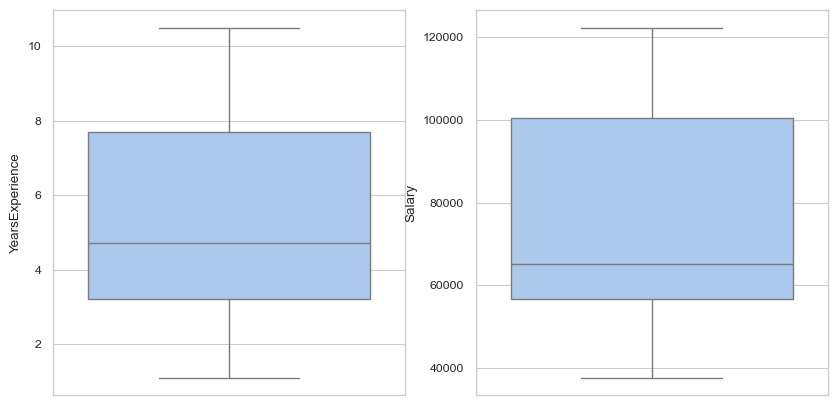

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data = df, y = 'YearsExperience', ax = ax[0])
sns.boxplot(data = df, y = 'Salary', ax = ax[1])
plt.show()

Possiamo osservare come non ci siano dei dati mancanti. Le distribuzioni dei dati sembrano avere una asimmetria sulla destra, con una coda piuttosto lunga per il salario. Vediamo se le distribuzioni di probabilità riflettono questo aspetto:

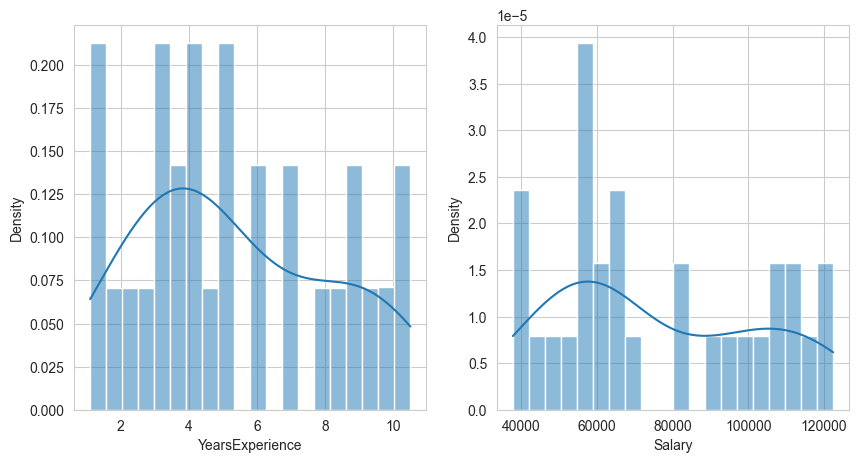

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(df['YearsExperience'], kde=True, stat='density', ax = ax[0], bins=20)
sns.histplot(df['Salary'], kde=True, stat='density', ax = ax[1], bins=20)
plt.show()

### 1.1.4 Data encoding

Non abbiamo dei dati categorici, per cui non abbiamo necessità di questo step.

## 1.2 Tecniche di feature scaling

L'obiettivo è quello di modificare le feature al fine di uniformarle all'interno di range confrontabili, per evitare che, nel calcolo di distanze o metriche simili, ve ne sia una dominante rispetto all'altra. Nel nostro dataset, abbiamo degli stipendi che sono nell'ordine delle decine di migliaia e degli anni di esperienza nel'ordine delle unità (o al massimo poche decine).

Vediamo cosa accade con due osservazioni in cui modifichiamo in modo significativo gli anni di esperienza e poi cosa accade quando cambiamo di poco lo stipendio:

In [14]:
import numpy as np

salary = [50_000, 50_000]
years = [5, 40]

print(np.sqrt((salary[0]-salary[1])**2 + (years[0]-years[1])**2))

35.0


In [15]:
salary = [50_000, 48_000]
years = [40, 40]

print(np.sqrt((salary[0]-salary[1])**2 + (years[0]-years[1])**2))

2000.0


Vediamo che gli ordini di grandezza si riflettono sulle distanze. Se cambiassimo entrambe le variabili, lo stipendio sarebbe nettamente dominante:

In [16]:
salary = [50_000, 48_000]
years = [5, 40]

print(np.sqrt((salary[0]-salary[1])**2 + (years[0]-years[1])**2))

2000.306226556324


Per questo motivo, ricorriamo al feature scaling nella maggior parte dei progetti di ML o AI (non tutti però, come vedremo con la regressione). Valutiamo i diversi approcci e l'impatto che hanno sul nostro dataset. Per farlo, importiamo il modulo [scikit-learn](https://scikit-learn.org/stable/):
1. **min-max scaling**: riportiamo i dati nel range [0, 1] sfruttando la classe [MinMaxScaler](https://scikit-learn.org/0.15/modules/generated/sklearn.preprocessing.MinMaxScaler.html) di sklearn.preprocessing

In [27]:
from sklearn.preprocessing import MinMaxScaler

df_min_max = df.copy(deep=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df_min_max[['YearsExperience', 'Salary']] = scaler.fit_transform(df_min_max[['YearsExperience', 'Salary']])
df_min_max

YearsExperience    Salary
0          0.000000  0.019041
1          0.021277  0.100094
2          0.042553  0.000000
3          0.095745  0.068438
4          0.117021  0.025514
5          0.191489  0.223376
6          0.202128  0.264812
7          0.223404  0.197425
8          0.223404  0.315545
9          0.276596  0.229837
10         0.297872  0.301051
11         0.308511  0.213359
12         0.308511  0.227097
13         0.319149  0.228561
14         0.361702  0.276163
15         0.404255  0.356804
16         0.425532  0.334255
17         0.446809  0.535755
18         0.510638  0.515379
19         0.521277  0.663938
20         0.606383  0.637928
21         0.638298  0.715119
22         0.723404  0.750898
23         0.755319  0.898665
24         0.808511  0.846917
25         0.840426  0.801453
26         0.893617  0.935956
27         0.904255  0.884763
28         0.978723  1.000000
29         1.000000  0.993870

Per vedere l'impatto sulle feature, creiamo uno scatterplot dei dati:

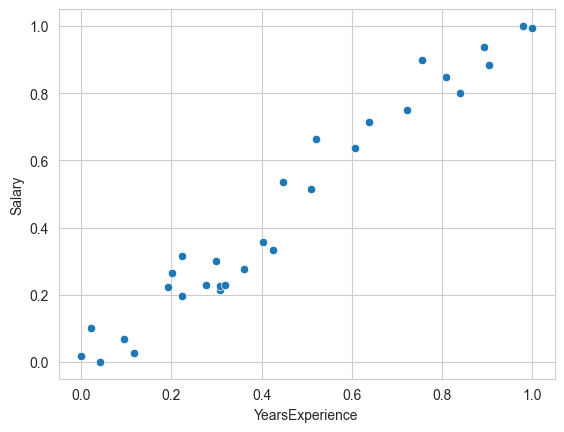

In [28]:
fig, ax = plt.subplots()

sns.scatterplot(data=df_min_max, x='YearsExperience', y='Salary', ax=ax)

plt.show()

2. **z-score**: in questo caso, i dati vengono normalizzati. Per applicarla, ricorriamo alla classe [StandardScaler](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html): 

In [29]:
from sklearn.preprocessing import StandardScaler

df_zscore = df.copy(deep=True)

scaler = StandardScaler()
df_zscore[['YearsExperience', 'Salary']] = scaler.fit_transform(df_zscore[['YearsExperience', 'Salary']])
df_zscore

YearsExperience    Salary
0         -1.510053 -1.360113
1         -1.438373 -1.105527
2         -1.366693 -1.419919
3         -1.187494 -1.204957
4         -1.115814 -1.339781
5         -0.864935 -0.718307
6         -0.829096 -0.588158
7         -0.757416 -0.799817
8         -0.757416 -0.428810
9         -0.578216 -0.698013
10        -0.506537 -0.474333
11        -0.470697 -0.749769
12        -0.470697 -0.706620
13        -0.434857 -0.702020
14        -0.291498 -0.552504
15        -0.148138 -0.299217
16        -0.076458 -0.370043
17        -0.004779  0.262859
18         0.210261  0.198860
19         0.246100  0.665476
20         0.532819  0.583780
21         0.640339  0.826233
22         0.927058  0.938611
23         1.034577  1.402741
24         1.213777  1.240203
25         1.321296  1.097402
26         1.500496  1.519868
27         1.536336  1.359074
28         1.787215  1.721028
29         1.858894  1.701773

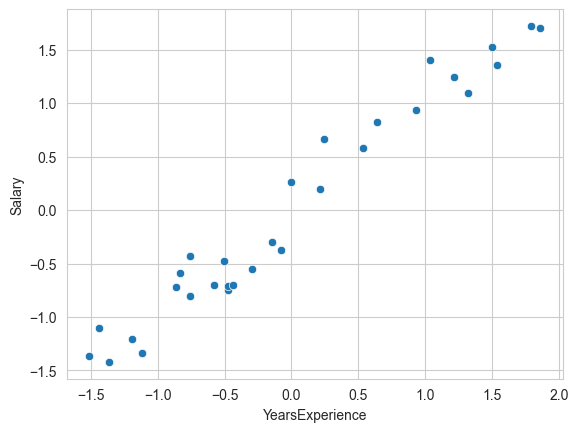

In [31]:
fig, ax = plt.subplots()

sns.scatterplot(data=df_zscore, x='YearsExperience', y='Salary', ax=ax)

plt.show()

3. **robust**: aprroccio simile al min-max, ma che si basa sui quartili. Per applicarlo, ricorriamo alla classe [RobustScaler](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.RobustScaler.html):

In [32]:
from sklearn.preprocessing import RobustScaler

df_robust = df.copy(deep=True)

scaler = RobustScaler()
df_robust[['YearsExperience', 'Salary']] = scaler.fit_transform(df_robust[['YearsExperience', 'Salary']])
df_robust

YearsExperience    Salary
0         -0.800000 -0.590863
1         -0.755556 -0.434283
2         -0.711111 -0.627647
3         -0.600000 -0.495436
4         -0.555556 -0.578359
5         -0.400000 -0.196125
6         -0.377778 -0.116078
7         -0.333333 -0.246258
8         -0.333333 -0.018072
9         -0.222222 -0.183644
10        -0.177778 -0.046071
11        -0.155556 -0.215476
12        -0.155556 -0.188938
13        -0.133333 -0.186108
14        -0.044444 -0.094149
15         0.044444  0.061633
16         0.088889  0.018072
17         0.133333  0.407334
18         0.266667  0.367972
19         0.288889  0.654961
20         0.466667  0.604714
21         0.533333  0.753834
22         0.711111  0.822951
23         0.777778  1.108411
24         0.888889  1.008443
25         0.955556  0.920614
26         1.066667  1.180449
27         1.088889  1.081553
28         1.244444  1.304171
29         1.288889  1.292328

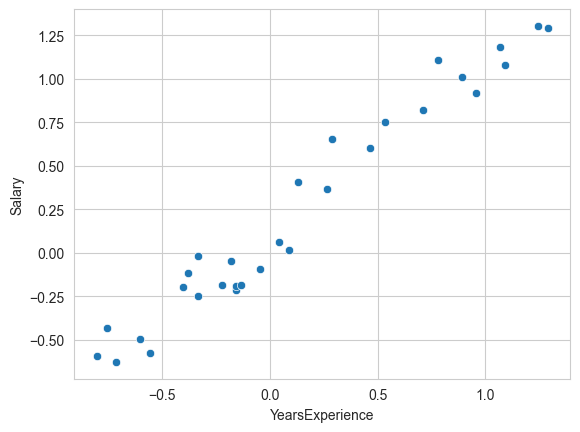

In [33]:
fig, ax = plt.subplots()

sns.scatterplot(data=df_robust, x='YearsExperience', y='Salary', ax=ax)

plt.show()

**NOTA: lo scaling va applicato solo dopo lo split tra train e test set. Gli esempi riportati sopra sono per valutare l'impatto delle diverse trasformazioni!**

# 2 Addestramento del modello

Per valutare quanto il nostro modello è accurato rispetto ad altri o per valutare la correttezza delle previsioni, occorre suddividere i dati a disposizione in almeno due insiemi:
- il **training set** su cui addestriamo la rete;
- il **test set** sui cui valutiamo le prestazioni.

Infatti, se addestrassimo la rete su tutti i dati a disposizione, otterremmo facilmente delle prestazioni superiori alla realtà in quanto le predizioni di test sarebbero fatte su dei dati usati per allenare il modello. Ci sono diverse soluzioni per lo split.

## 2.1 holdout

In questo caso, definiamo una percentuale che indichi quanti dati manterenere nel test set, mentre i restanti andranno nel training set e saranno utilizzati per addestrare il modello. Per questo approccio, utilizziamo la funzione [train_test_split](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html). Tra i suoi argomenti di ingresso, i più importanti sono:
- test_size: dimensione del test set, definita come un rapporto tra 0.0 e 1.0;
- train_size: se si definisce il test_size, non occorre indicarla, ma è comunque un rapporto tra 0.0 e 1.0 per il training set;
- random_state: seed del generatore pseudo-casuale.

Prima di applicarlo, creiamo degli array che contengano le variabili indipendenti e quella dipendente. Nel nostro esempio, potremmo considerare gli anni di esperienza come la IV e lo stipendio come DV. Poiché il feature scaling deve essere effettuato solo sul training set, prendiamo il dataset a valle del data cleaning:

In [37]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]  # tutte le colonne tranne l'ultima
y = df.iloc[:, -1]  # ultima colonna

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [50]:
X_test.index

Index([2, 28, 13, 10, 26, 24], dtype='int64')

In [49]:
X_train.index

Index([27, 11, 17, 22,  5, 16,  8, 14, 23, 20,  1, 29,  6,  4, 18, 19,  9,  7,
       25,  3,  0, 21, 15, 12],
      dtype='int64')

## 2.2 k-fold

In questo caso, creaimo $k$ sotto-insiemi e ripetiamo l'addestramento e la valutazione del modello $k$ volte. Ad ogni iterazione, si cambia il sotto-insieme per il test (e quindi quelli per il training). Per applicarlo, ricorriamo alla classe [KFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html):

In [52]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, random_state=0, shuffle=True)
# cosa accade se shuffle è False?

print(kf)

KFold(n_splits=4, random_state=0, shuffle=True)


In questo oggetto, abbiamo già il generatore degli indici definito in base a come abbiamo creato il KFold:

In [54]:
print(kf.split(X, y))

<generator object _BaseKFold.split at 0x1649cb640>


Per addestrare e valutare la rete, dovremo usare un ciclo:

In [55]:
counter = 1
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{counter}, Train set: {train_index}, Test set:{test_index}')
    counter += 1

Fold:1, Train set: [ 0  1  3  4  5  6  7  8  9 12 14 15 16 17 18 19 20 21 22 23 25 29], Test set:[ 2 10 11 13 24 26 27 28]
Fold:2, Train set: [ 0  1  2  3  4  6  7  9 10 11 12 13 15 18 19 21 24 25 26 27 28 29], Test set:[ 5  8 14 16 17 20 22 23]
Fold:3, Train set: [ 0  2  3  5  7  8 10 11 12 13 14 15 16 17 20 21 22 23 24 25 26 27 28], Test set:[ 1  4  6  9 18 19 29]
Fold:4, Train set: [ 1  2  4  5  6  8  9 10 11 13 14 16 17 18 19 20 22 23 24 26 27 28 29], Test set:[ 0  3  7 12 15 21 25]
